In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import joblib
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore")

In [2]:
bikes=pd.read_csv('bikes.csv')
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500


# Creating Class function for data cleaning and Preprocessing

In [3]:
class BikePreprocess:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
    
    def bike_preprocess_mileage(self):
        self.df["mileage"]= self.df["mileage"].str.strip()
        self.df["mileage"] = self.df["mileage"].str.replace(" kmpl", "")
        self.df["mileage"]=self.df["mileage"].apply(lambda x: x[:2] if isinstance(x, str) else x)
        self.df["mileage"] = self.df["mileage"].astype(int, errors='ignore')
        # Mileage colmn values reflected as string, converting to numeric
        self.df["mileage"]=pd.to_numeric(self.df["mileage"].astype(int, errors='ignore').values, errors='coerce')
        # Engineered a new column for brand name from model_name
        self.df["brand"] = self.df["model_name"].apply(lambda x: x.split(" ")[0])
        # Calculate mean mileage per brand
        brand_means = self.df.groupby('brand')['mileage'].mean()
        # Fillna using map
        self.df['mileage'].fillna(self.df['brand'].map(brand_means), inplace=True)
        self.df["mileage"].fillna(30, inplace=True)
        self.df[["model_name", "brand", "location"]]=self.df[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)
        return self.df
    
    def power_column(self):
        # Ensure model_name, brand, and location are in title case
        self.df[["model_name", "brand", "location"]]=self.df[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)
        power_bhp=lambda x: re.sub(r'[a-zA-Z]', '',  x.split(" ")[0])[:3] if isinstance(x, str) else x
        self.df["power"]=self.df["power"].apply(power_bhp)
        self.df["power"]=pd.to_numeric(self.df["power"].astype(float).values, errors='coerce')
        brand_means_power = self.df.groupby('brand')['power'].mean()
        self.df['power'].fillna(self.df['brand'].map(brand_means_power), inplace=True)
        self.df["power"].fillna(self.df["power"].mean(), inplace=True)
        return self.df
    
    def extract_cc_column(self):
        def extract_cc(value_list):
            """
            Extracts CC value from a list of tokens.
            Returns integer CC value if found, else None.
            """
            if not isinstance(value_list, list):
                return None
            
            for token in value_list:
                match = re.search(r'(\d{2,4})\s*Cc', token, re.IGNORECASE)
                if match:
                    return int(match.group(1))
                
                # Some entries may just have '220' without 'Cc'
                if token.isdigit() and 50 < int(token) < 1000:  # simple sanity check
                    return int(token)
            
            return None
        cc=lambda x: extract_cc(x.split(" "))
        self.df["cc"] = self.df["model_name"].apply(cc)
        brand_means_cc = self.df.groupby('brand')['cc'].mean()
        self.df['cc'].fillna(self.df['brand'].map(brand_means_cc), inplace=True)
        self.df["cc"].fillna(self.df["cc"].mean(), inplace=True)
        return self.df
    
    def kms_driven_clean(self):
        self.df["kms_driven"].str.title()
        self.df["kms_driven"].str.strip()
        kms_value=lambda x: re.findall(r'-?\d+\.?\d*', x)
        self.df["kms_driven"].apply(kms_value)
        self.df["kms_driven"]=self.df["kms_driven"].apply(kms_value)
        def clean_kms(x):
            if isinstance(x, list) and len(x) == 1:
                try:
                    return float(x[0])
                except ValueError:
                    return np.nan
            elif isinstance(x, str):
                try:
                    return float(x)
                except ValueError:
                    return np.nan
            else:
                return np.nan

        self.df["kms_driven"] = self.df["kms_driven"].apply(clean_kms)
        brand_means_kms = self.df.groupby('brand')['kms_driven'].mean()
        self.df['kms_driven'].fillna(self.df['brand'].map(brand_means_kms), inplace=True)
        return self.df
    
    def textformat(self):
        self.df[["model_name", "brand", "location"]]=self.df[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)
        return self.df
    
    def owner_prperocess(self):
        self.df["owner"] = self.df["owner"].str.strip()
        #self.df["owner"] = self.df["owner"].apply(lambda x: x.str.title() if isinstance(x, str) else x)
        self.df["owner"].replace({"first owner": 1, "second owner": 2, "third owner": 3, "fourth owner or more": 4}, inplace=True)
        self.df["owner"] = self.df["owner"].replace({"First Owner": 1, "Second Owner": 2, "Third Owner": 3, "Fourth & Above Owner": 4})
        #self.df["owner"] = pd.to_numeric(self.df["owner"], errors='coerce')
        self.df["owner"].fillna(1, inplace=True)
        return self.df


# Processing functions for the dataset
    def preprocess_dataset(self):
        try:
            self.bike_preprocess_mileage()
        except Exception as e:
            print(f"Error in bike_preprocess_mileage: {e}")
        try:
            self.power_column()
        except Exception as e:
            print(f"Error in power_column: {e}")
        try:
            self.extract_cc_column()
        except Exception as e:
            print(f"Error in extract_cc_column: {e}")
        try:
            self.kms_driven_clean()
        except Exception as e:
            print(f"Error in kms_driven_clean: {e}")
        try:
            self.owner_prperocess()
        except Exception as e:
            print(f"Error in owner_prperocess: {e}")
        try:
            self.textformat()
        except Exception as e:
            print(f"Error in textformat: {e}")
        return self.df

    

In [4]:
bikes

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500
...,...,...,...,...,...,...,...,...
7852,Yamaha YZF-R15 150cc 2011,2011,7000 Km,first owner,agra,\n\n 42 kmpl,16 bhp,55000
7853,Bajaj Discover 100cc 2015,2015,Mileage 80 Kmpl,first owner,delhi,\n\n 80 Kmpl,7.7,28000
7854,Bajaj Pulsar 180cc 2016,2016,6407 Km,first owner,bangalore,\n\n 65 kmpl,17 bhp,61740
7855,Bajaj V15 150cc 2016,2016,7524 Km,first owner,bangalore,\n\n 57 kmpl,11.80 bhp,49000


In [5]:
bikes.describe()

,model_year,price
count,7857.000000,7.857000e+03
mean,2015.367698,1.067913e+05
std,4.001443,1.389261e+05
min,1950.000000,0.000000e+00
25%,2014.000000,4.200000e+04
50%,2016.000000,7.500000e+04
75%,2018.000000,1.250000e+05
max,2021.000000,3.000000e+06


In [6]:
bikes.shape

(7857, 8)

In [7]:
bikes.dtypes

model_name    object
model_year     int64
kms_driven    object
owner         object
location      object
mileage       object
power         object
price          int64
dtype: object

In [8]:
bikes["mileage"].str.strip()

0       35 kmpl
1       35 kmpl
2       30 kmpl
3        28 Kms
4              
         ...   
7852    42 kmpl
7853    80 Kmpl
7854    65 kmpl
7855    57 kmpl
7856    38 kmpl
Name: mileage, Length: 7857, dtype: object

# Preprocessing Dataset

## Mileage columns

In [9]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,\n\n 35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,\n\n 35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,\n\n 30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,\n\n 28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,\n\n,30 bhp,197500


In [10]:
bikes["mileage"]= bikes["mileage"].str.strip()

In [11]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,35 kmpl,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,35 kmpl,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,30 kmpl,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,,30 bhp,197500


In [12]:
bikes["mileage"] = bikes["mileage"].str.replace(" kmpl", "")

In [13]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,35,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,35,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,30,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,28 Kms,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,,30 bhp,197500


In [14]:
bikes["mileage"]=bikes["mileage"].apply(lambda x: x[:2] if isinstance(x, str) else x)

In [15]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,35,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,35,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,30,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,28,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,,30 bhp,197500


In [16]:
bikes["mileage"] = bikes["mileage"].astype(int, errors='ignore')

In [17]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,first owner,hyderabad,35,19 bhp,63500
1,Royal Enfield Classic 350cc 2016,2016,50000 Km,first owner,hyderabad,35,19.80 bhp,115000
2,Hyosung GT250R 2012,2012,14795 Km,first owner,hyderabad,30,28 bhp,300000
3,Bajaj Dominar 400 ABS 2017,2017,Mileage 28 Kms,first owner,pondicherry,28,34.50 bhp,100000
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,,30 bhp,197500


In [18]:
bikes.isnull().sum()

model_name     0
model_year     0
kms_driven     0
owner          0
location      19
mileage       11
power         31
price          0
dtype: int64

In [19]:
# Mileage colmn values reflected as string, converting to numeric
bikes["mileage"]=pd.to_numeric(bikes["mileage"].astype(int, errors='ignore').values, errors='coerce')

In [20]:
bikes.dtypes

model_name     object
model_year      int64
kms_driven     object
owner          object
location       object
mileage       float64
power          object
price           int64
dtype: object

In [21]:
bikes.describe()

,model_year,mileage,price
count,7857.000000,7083.000000,7.857000e+03
mean,2015.367698,44.168855,1.067913e+05
std,4.001443,16.531119,1.389261e+05
min,1950.000000,5.000000,0.000000e+00
25%,2014.000000,35.000000,4.200000e+04
50%,2016.000000,40.000000,7.500000e+04
75%,2018.000000,57.000000,1.250000e+05
max,2021.000000,96.000000,3.000000e+06


In [22]:
bikes[bikes["model_name"].str.contains("Jawa")].head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,NaN,30 bhp,197500
157,Jawa Forty Two 295CC 2019,2019,4930 Km,first owner,moradabad,NaN,27 bhp,140000
211,Jawa Forty Two 295CC Dual ABS BS6 2020,2020,5000 Km,first owner,pune,NaN,27 bhp,190000
300,Jawa Forty Two 295CC 2019,2019,600 Km,first owner,ludhiana,NaN,27 bhp,162000
347,Jawa Forty Two 295CC 2019,2019,3200 Km,first owner,ghaziabad,NaN,27 bhp,160000


In [23]:
bikes[bikes["mileage"] == "Li"]

,model_name,model_year,kms_driven,owner,location,mileage,power,price


In [24]:
bikes[bikes['mileage'].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,NaN,30 bhp,197500
40,Bajaj Discover 110cc 2019,2019,45000 Km,first owner,chittorgarh,NaN,8.60 bhp,46000
50,Royal Enfield Bullet 350cc 2019,2019,27300 Km,first owner,hyderabad,NaN,19.80 bhp,130000
62,Royal Enfield Thunderbird X 350cc ABS 2019,2019,9000 Km,first owner,mumbai,NaN,19.80 bhp,166000
63,TVS Apache RTR 160 4V DISC ABS 2019,2019,21500 Km,first owner,hyderabad,NaN,16.1 bhp,93000
...,...,...,...,...,...,...,...,...
7815,Honda Livo 110cc 2019,2019,15492 Km,first owner,jaipur,NaN,8.25 Bhp,53214
7816,Bajaj Discover 135cc 2010,2010,21728 Km,first owner,chennai,NaN,9.64 kw,16000
7832,Bajaj Discover 135cc 2009,2009,18000 Km,first owner,delhi,NaN,9.64 kw,21000
7837,Bajaj Discover 135cc 2009,2009,25000 Km,first owner,delhi,NaN,9.64 kw,22000


In [25]:
# Engineered a new column for brand name from model_name
brand=lambda x : x.split(" ")[0]
bikes["brand"]=bikes["model_name"].apply(brand)


In [26]:
bikes["brand"].value_counts()

brand
Bajaj               2105
Royal               1750
Hero                 808
Yamaha               747
TVS                  567
Honda                530
KTM                  491
Suzuki               223
Harley-Davidson      171
UM                   128
Kawasaki              67
Hyosung               54
Benelli               53
Jawa                  46
Triumph               36
Mahindra              27
Ducati                16
Husqvarna             11
BMW                   10
BenelliImperiale       6
MV                     2
Fb                     2
Aprilia                2
Ideal                  1
Indian                 1
Moto                   1
Yazdi                  1
yamaha                 1
Name: count, dtype: int64

In [27]:
bikes.pivot_table(index='brand', values='mileage', aggfunc='mean').sort_values(by='mileage', ascending=False)

,mileage
brand,
Honda,56.576000
Hero,52.710938
TVS,51.544086
Suzuki,50.846154
Bajaj,50.025602
Mahindra,49.038462
Yamaha,47.547541
BenelliImperiale,35.000000
UM,35.000000


In [28]:
# Calculate mean mileage per brand
brand_means = bikes.groupby('brand')['mileage'].mean()

# Fillna using map
bikes['mileage'].fillna(bikes['brand'].map(brand_means), inplace=True)


In [29]:
bikes[bikes["brand"] == "Jawa"].head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,NaN,30 bhp,197500,Jawa
157,Jawa Forty Two 295CC 2019,2019,4930 Km,first owner,moradabad,NaN,27 bhp,140000,Jawa
211,Jawa Forty Two 295CC Dual ABS BS6 2020,2020,5000 Km,first owner,pune,NaN,27 bhp,190000,Jawa
300,Jawa Forty Two 295CC 2019,2019,600 Km,first owner,ludhiana,NaN,27 bhp,162000,Jawa
347,Jawa Forty Two 295CC 2019,2019,3200 Km,first owner,ghaziabad,NaN,27 bhp,160000,Jawa


In [30]:
bikes[bikes["mileage"].notnull()][bikes["brand"]== "Jawa"]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand


In [31]:
bikes[bikes["brand"]== "Jawa"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,NaN,30 bhp,197500,Jawa
157,Jawa Forty Two 295CC 2019,2019,4930 Km,first owner,moradabad,NaN,27 bhp,140000,Jawa


In [32]:
bikes[bikes["brand"] == "BMW"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
2023,BMW G 310 R 2018,2018,8500 Km,first owner,mumbai,NaN,33 bhp,260000,BMW
2832,BMW G 310 R 2019,2019,9000 Km,first owner,mumbai,NaN,33 bhp,270000,BMW


In [33]:
bikes["mileage"].fillna(30, inplace=True)

In [34]:
bikes[bikes["brand"] == "BMW"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
2023,BMW G 310 R 2018,2018,8500 Km,first owner,mumbai,30.0,33 bhp,260000,BMW
2832,BMW G 310 R 2019,2019,9000 Km,first owner,mumbai,30.0,33 bhp,270000,BMW


In [35]:
bikes[bikes["brand"]== "Jawa"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
4,Jawa Perak 330cc 2020,2020,2000 Km,first owner,bangalore,30.0,30 bhp,197500,Jawa
157,Jawa Forty Two 295CC 2019,2019,4930 Km,first owner,moradabad,30.0,27 bhp,140000,Jawa


In [36]:
bikes.describe()

,model_year,mileage,price
count,7857.000000,7857.000000,7.857000e+03
mean,2015.367698,44.053529,1.067913e+05
std,4.001443,15.999072,1.389261e+05
min,1950.000000,5.000000,0.000000e+00
25%,2014.000000,35.000000,4.200000e+04
50%,2016.000000,40.000000,7.500000e+04
75%,2018.000000,55.000000,1.250000e+05
max,2021.000000,96.000000,3.000000e+06


In [37]:
bikes["owner"].replace({"first owner": 1, "second owner": 2, "third owner": 3, "fourth owner or more": 4}, inplace=True)

In [38]:
bikes[bikes['mileage'].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand


### Creating function for cleaning data set

In [39]:
def bike_preprocess_mileage(df):
    df["mileage"]= df["mileage"].str.strip()
    df["mileage"] = df["mileage"].str.replace(" kmpl", "")
    df["mileage"]=df["mileage"].apply(lambda x: x[:2] if isinstance(x, str) else x)
    df["mileage"] = df["mileage"].astype(int, errors='ignore')
    # Mileage colmn values reflected as string, converting to numeric
    df["mileage"]=pd.to_numeric(df["mileage"].astype(int, errors='ignore').values, errors='coerce')
    # Engineered a new column for brand name from model_name
    df["brand"] = df["model_name"].apply(lambda x: x.split(" ")[0])
    # Calculate mean mileage per brand
    brand_means = df.groupby('brand')['mileage'].mean()
    # Fillna using map
    df['mileage'].fillna(df['brand'].map(brand_means), inplace=True)
    df["mileage"].fillna(30, inplace=True)
    df[["model_name", "brand", "location"]]=df[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)
    return df

In [40]:
data1=pd.read_csv('bikes.csv')
bikes1=bike_preprocess_mileage(data1.copy())
bike=bike_preprocess_mileage(data1)
bikes1[bikes1["brand"] == "Jawa"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
4,Jawa Perak 330Cc 2020,2020,2000 Km,first owner,Bangalore,30.0,30 bhp,197500,Jawa
157,Jawa Forty Two 295Cc 2019,2019,4930 Km,first owner,Moradabad,30.0,27 bhp,140000,Jawa


## Power Column

In [41]:
# Capitalized First character of each word in model_name, brand, and location
lambda x: x.str.title()
bikes[["model_name", "brand", "location"]]=bikes[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)

In [42]:
bikes[bikes["power"].isnull()]["brand"].value_counts()

brand
Royal              7
Harley-Davidson    7
Hero               6
Hyosung            3
Yamaha             2
Bajaj              2
Benelli            2
Ideal              1
Triumph            1
Name: count, dtype: int64

In [43]:
# Cleaning the power column
power_bhp=lambda x: re.sub(r'[a-zA-Z]', '',  x.split(" ")[0])[:3] if isinstance(x, str) else x

In [44]:
bikes["power"]=bikes["power"].apply(power_bhp)
bikes["power"]=pd.to_numeric(bikes["power"].astype(float).values, errors='coerce')

### Creating function for Power column

In [45]:
def power_column(df):
    df[["model_name", "brand", "location"]]=df[["model_name", "brand", "location"]].apply(lambda x: x.str.title() if x.dtype == "object" else x)
    power_bhp=lambda x: re.sub(r'[a-zA-Z]', '',  x.split(" ")[0])[:3] if isinstance(x, str) else x
    df["power"]=df["power"].apply(power_bhp)
    df["power"]=pd.to_numeric(df["power"].astype(float).values, errors='coerce')
    brand_means_power = df.groupby('brand')['power'].mean()
    df['power'].fillna(df['brand'].map(brand_means_power), inplace=True)
    df["power"].fillna(df["power"].mean(), inplace=True)
    return df

In [46]:
brand_means_power = bikes.groupby('brand')['power'].mean()
bikes['power'].fillna(bikes['brand'].map(brand_means_power), inplace=True)
bikes["power"].fillna(bikes["power"].mean(), inplace=True)

In [47]:
test_bike = BikePreprocess(pd.read_csv('bikes.csv'))
bikes_n=test_bike.preprocess_dataset()
bikes_n

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.0
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.0
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,250.0
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.0
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,Yamaha Yzf-R15 150Cc 2011,2011,7000.0,1,Agra,42.0,16.0,55000,Yamaha,150.0
7853,Bajaj Discover 100Cc 2015,2015,80.0,1,Delhi,80.0,7.7,28000,Bajaj,100.0
7854,Bajaj Pulsar 180Cc 2016,2016,6407.0,1,Bangalore,65.0,17.0,61740,Bajaj,180.0
7855,Bajaj V15 150Cc 2016,2016,7524.0,1,Bangalore,57.0,11.0,49000,Bajaj,150.0


In [48]:
bikes_n.isnull().sum()

model_name     0
model_year     0
kms_driven     0
owner          0
location      19
mileage        0
power          0
price          0
brand          0
cc             0
dtype: int64

In [49]:
bikes.head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,1,Hyderabad,35.0,19.0,63500,Bajaj
1,Royal Enfield Classic 350Cc 2016,2016,50000 Km,1,Hyderabad,35.0,19.0,115000,Royal


In [50]:
bikes.describe()

,model_year,owner,mileage,power,price
count,7857.000000,7857.000000,7857.000000,7857.000000,7.857000e+03
mean,2015.367698,1.168003,44.053529,20.486665,1.067913e+05
std,4.001443,0.479232,15.999072,15.045326,1.389261e+05
min,1950.000000,1.000000,5.000000,6.100000,0.000000e+00
25%,2014.000000,1.000000,35.000000,14.000000,4.200000e+04
50%,2016.000000,1.000000,40.000000,19.000000,7.500000e+04
75%,2018.000000,1.000000,55.000000,24.000000,1.250000e+05
max,2021.000000,4.000000,96.000000,197.000000,3.000000e+06


In [51]:
bikes.describe()

,model_year,owner,mileage,power,price
count,7857.000000,7857.000000,7857.000000,7857.000000,7.857000e+03
mean,2015.367698,1.168003,44.053529,20.486665,1.067913e+05
std,4.001443,0.479232,15.999072,15.045326,1.389261e+05
min,1950.000000,1.000000,5.000000,6.100000,0.000000e+00
25%,2014.000000,1.000000,35.000000,14.000000,4.200000e+04
50%,2016.000000,1.000000,40.000000,19.000000,7.500000e+04
75%,2018.000000,1.000000,55.000000,24.000000,1.250000e+05
max,2021.000000,4.000000,96.000000,197.000000,3.000000e+06


In [52]:
bikes.dtypes

model_name     object
model_year      int64
kms_driven     object
owner           int64
location       object
mileage       float64
power         float64
price           int64
brand          object
dtype: object

In [53]:
bikes[bikes["power"].isnull()].head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand


In [54]:
bikes.head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,1,Hyderabad,35.0,19.0,63500,Bajaj
1,Royal Enfield Classic 350Cc 2016,2016,50000 Km,1,Hyderabad,35.0,19.0,115000,Royal


In [55]:
bikes[bikes["model_name"].str.contains("cc")]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
1302,Hero Splendor Plus Black And Accent Edition 2020,2020,10000 Km,1,Ahmedabad,55.0,7.9,70000,Hero
1430,Hero Splendor Plus Black And Accent Edition 2021,2021,12500 Km,1,Hardoi,55.0,7.9,700000,Hero
1890,Hero Splendor Plus Black And Accent Edition 2020,2020,3270 Km,1,Delhi,55.0,7.9,60000,Hero


In [56]:
# Null values count by brand
bikes[bikes['mileage'].isnull()]['brand'].value_counts()

Series([], Name: count, dtype: int64)

In [57]:
bikes.shape

(7857, 9)

In [58]:
bikes["owner"].unique()

array([1, 3, 2, 4])

In [59]:
bikes.nunique()

model_name    1721
model_year      36
kms_driven    1801
owner            4
location       561
mileage         80
power          117
price         1627
brand           27
dtype: int64

## CC Column

In [60]:
bikes.head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,1,Hyderabad,35.0,19.0,63500,Bajaj
1,Royal Enfield Classic 350Cc 2016,2016,50000 Km,1,Hyderabad,35.0,19.0,115000,Royal


### Creating Function for cc column extraction

In [61]:
def extract_cc(value_list):
    """
    Extracts CC value from a list of tokens.
    Returns integer CC value if found, else None.
    """
    if not isinstance(value_list, list):
        return None
    
    for token in value_list:
        match = re.search(r'(\d{2,4})\s*Cc', token, re.IGNORECASE)
        if match:
            return int(match.group(1))
        
        # Some entries may just have '220' without 'Cc'
        if token.isdigit() and 50 < int(token) < 1000:  # simple sanity check
            return int(token)
    
    return None


In [62]:
cc=lambda x: extract_cc(x.split(" "))

In [63]:
bikes["cc"]=bikes["model_name"].apply(cc)

In [64]:
bikes[bikes["cc"].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
2,Hyosung Gt250R 2012,2012,14795 Km,1,Hyderabad,30.0,28.0,300000,Hyosung,NaN
15,Bajaj Pulsar Ns200 2018,2018,Mileage 42 Kmpl,3,Delhi,42.0,23.0,53000,Bajaj,NaN
30,Bajaj Pulsar Ns200 Abs 2020,2020,Mileage 42 Kmpl,1,Delhi,42.0,23.0,118000,Bajaj,NaN
31,Bajaj Pulsar 220F 2016,2016,26683 Km,1,Delhi,38.0,21.0,65000,Bajaj,NaN
32,Um Renegade Commando Mojave 2018,2018,6900 Km,1,Bangalore,35.0,24.0,148000,Um,NaN
...,...,...,...,...,...,...,...,...,...,...
7821,Bajaj Discover 100M 2014,2014,Mileage 80 Kmpl,1,Delhi,80.0,9.1,38800,Bajaj,NaN
7828,Bajaj Pulsar As150 2016,2016,9000 Km,1,Patna,53.0,16.0,60000,Bajaj,NaN
7839,Bajaj Discover 125St 2013,2013,40000 Km,1,Chennai,65.0,12.0,22000,Bajaj,NaN
7845,Bajaj Discover 100M 2012,2012,Mileage 80 Kmpl,1,Delhi,80.0,9.1,35000,Bajaj,NaN


In [65]:
bikes["model_name"].value_counts().sort_values(ascending=False)

model_name
Royal Enfield Classic 350Cc 2017        78
Royal Enfield Classic 350Cc 2016        69
Royal Enfield Classic 350Cc 2015        68
Royal Enfield Thunderbird 350Cc 2015    64
Royal Enfield Classic 350Cc 2018        59
                                        ..
Bajaj Discover 110Cc 2010                1
Hero Splendor Plus 100 2009              1
Hero Passion Pro  100 Cc 2004            1
Hero Splendor 100Cc 2003                 1
Hero Karizma 223 Cc 2008                 1
Name: count, Length: 1721, dtype: int64

In [66]:
bikes[bikes["model_name"]=='Hero Karizma 223 Cc 2008']

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
7649,Hero Karizma 223 Cc 2008,2008,22000 Km,1,Delhi,52.710938,14.0,0,Hero,223.0


In [67]:
bikes[bikes["model_name"].duplicated()].sort_values(by="model_name")

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
3362,Bajaj Pulsar 180Cc 2008,2008,40000 Km,1,Gurgaon,45.0,17.0,20000,Bajaj,180.0
695,Bajaj Pulsar 180Cc 2008,2008,24000 Km,1,Mumbai,45.0,17.0,14000,Bajaj,180.0
5572,Bajaj Pulsar 180Cc 2011,2011,620010 Km,3,Kolkata,45.0,17.0,28000,Bajaj,180.0
4994,Bajaj Pulsar 180Cc 2011,2011,94000 Km,1,Delhi,45.0,17.0,20000,Bajaj,180.0
6724,Bajaj Pulsar 180Cc 2011,2011,55000 Km,1,Gurgaon,45.0,17.0,26000,Bajaj,180.0
...,...,...,...,...,...,...,...,...,...,...
3128,Yamaha Yzf-R3 320Cc 2016,2016,35000 Km,4,Bangalore,22.0,41.0,232000,Yamaha,320.0
4101,Yamaha Yzf-R3 320Cc 2016,2016,11000 Km,1,Mumbai,22.0,41.0,259375,Yamaha,320.0
3411,Yamaha Yzf-R3 320Cc 2016,2016,24000 Km,1,Coimbatore,22.0,41.0,240000,Yamaha,320.0
5792,Yamaha Yzf-R3 320Cc 2016,2016,6500 Km,2,Goa-Panaji,22.0,41.0,250000,Yamaha,320.0


In [68]:
bikes[bikes["cc"].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
2,Hyosung Gt250R 2012,2012,14795 Km,1,Hyderabad,30.0,28.0,300000,Hyosung,NaN
15,Bajaj Pulsar Ns200 2018,2018,Mileage 42 Kmpl,3,Delhi,42.0,23.0,53000,Bajaj,NaN
30,Bajaj Pulsar Ns200 Abs 2020,2020,Mileage 42 Kmpl,1,Delhi,42.0,23.0,118000,Bajaj,NaN
31,Bajaj Pulsar 220F 2016,2016,26683 Km,1,Delhi,38.0,21.0,65000,Bajaj,NaN
32,Um Renegade Commando Mojave 2018,2018,6900 Km,1,Bangalore,35.0,24.0,148000,Um,NaN
...,...,...,...,...,...,...,...,...,...,...
7821,Bajaj Discover 100M 2014,2014,Mileage 80 Kmpl,1,Delhi,80.0,9.1,38800,Bajaj,NaN
7828,Bajaj Pulsar As150 2016,2016,9000 Km,1,Patna,53.0,16.0,60000,Bajaj,NaN
7839,Bajaj Discover 125St 2013,2013,40000 Km,1,Chennai,65.0,12.0,22000,Bajaj,NaN
7845,Bajaj Discover 100M 2012,2012,Mileage 80 Kmpl,1,Delhi,80.0,9.1,35000,Bajaj,NaN


In [69]:
bikes["cc"].fillna(bikes["cc"].mean(), inplace=True)

In [70]:
bikes[bikes["cc"].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc


In [71]:
process=BikePreprocess(pd.read_csv('bikes.csv'))


In [72]:
brand_means_cc = bikes.groupby('brand')['cc'].mean()
bikes['cc'].fillna(bikes['brand'].map(brand_means_cc), inplace=True)

## kMS_Drive Column

### Creating Function for KMS Columns

In [73]:
def kms_driven_clean(df):
    df["kms_driven"].str.title()
    df["kms_driven"].str.strip()
    kms_value=lambda x: re.findall(r'-?\d+\.?\d*', x)
    df["kms_driven"].apply(kms_value)
    df["kms_driven"]=df["kms_driven"].apply(kms_value)
    def clean_kms(x):
        if isinstance(x, list) and len(x) == 1:
            try:
                return float(x[0])
            except ValueError:
                return np.nan
        elif isinstance(x, str):
            try:
                return float(x)
            except ValueError:
                return np.nan
        else:
            return np.nan

    df["kms_driven"] = df["kms_driven"].apply(clean_kms)
    return df


In [74]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000 Km,1,Hyderabad,35.0,19.0,63500,Bajaj,220.000000
1,Royal Enfield Classic 350Cc 2016,2016,50000 Km,1,Hyderabad,35.0,19.0,115000,Royal,350.000000
2,Hyosung Gt250R 2012,2012,14795 Km,1,Hyderabad,30.0,28.0,300000,Hyosung,249.194653
3,Bajaj Dominar 400 Abs 2017,2017,Mileage 28 Kms,1,Pondicherry,28.0,34.0,100000,Bajaj,400.000000
4,Jawa Perak 330Cc 2020,2020,2000 Km,1,Bangalore,30.0,30.0,197500,Jawa,330.000000


In [75]:
bikes["kms_driven"].str.title()
bikes["kms_driven"].str.strip()
kms_value=lambda x: re.findall(r'-?\d+\.?\d*', x)
bikes["kms_driven"].apply(kms_value)
bikes["kms_driven"]=bikes["kms_driven"].apply(kms_value)


In [76]:
def clean_kms(x):
    if isinstance(x, list) and len(x) == 1:
        try:
            return float(x[0])
        except ValueError:
            return np.nan
    elif isinstance(x, str):
        try:
            return float(x)
        except ValueError:
            return np.nan
    else:
        return np.nan

bikes["kms_driven"] = bikes["kms_driven"].apply(clean_kms)


In [77]:
bikes["kms_driven"].values

array([17000., 50000., 14795., ...,  6407.,  7524., 15000.], shape=(7857,))

In [78]:
brand_means_kms = bikes.groupby('brand')['kms_driven'].mean()
bikes['kms_driven'].fillna(bikes['brand'].map(brand_means_kms), inplace=True)

In [79]:
bikes[bikes["kms_driven"].isnull()]["model_name"].value_counts()

Series([], Name: count, dtype: int64)

# EDA

## Univariate Analysis

<Axes: >

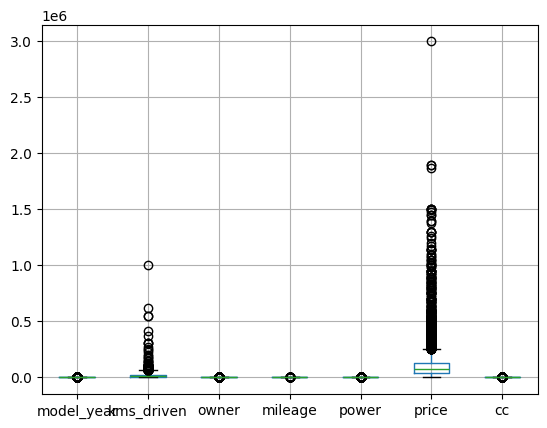

In [80]:
bikes.boxplot()

In [81]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.000000
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.000000
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,249.194653
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.000000
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.000000


In [82]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8));
bikes.boxplot(column='mileage', ax=axs[0, 0])
bikes.boxplot(column='power', ax=axs[0, 1])
bikes.boxplot(column='price', ax=axs[1, 0])
bikes.boxplot(column='kms_driven', ax=axs[1, 1]);

In [83]:
bikes[bikes.select_dtypes(include=['number']).columns.values].corr()

,model_year,kms_driven,owner,mileage,power,price,cc
model_year,1.000000,-0.230306,-0.134244,-0.142549,0.144645,0.227963,0.122249
kms_driven,-0.230306,1.000000,0.139237,0.028688,-0.090152,-0.114215,-0.054498
owner,-0.134244,0.139237,1.000000,-0.034603,0.029830,-0.048520,0.001882
mileage,-0.142549,0.028688,-0.034603,1.000000,-0.543653,-0.451119,-0.570169
power,0.144645,-0.090152,0.029830,-0.543653,1.000000,0.827381,0.584200
price,0.227963,-0.114215,-0.048520,-0.451119,0.827381,1.000000,0.549201
cc,0.122249,-0.054498,0.001882,-0.570169,0.584200,0.549201,1.000000


In [84]:
sns.heatmap(bikes[bikes.select_dtypes(include=['number']).columns.values].corr(), annot=True, cmap='coolwarm', fmt='.2f');

In [85]:
most_corr_col=["mileage", "power", "price", "cc"]

In [86]:
sns.countplot(x="owner", data=bikes);

In [87]:
fig, ax = plt.subplots(figsize=(25, 16))
sns.countplot(x="brand", data=bikes, ax=ax);

In [88]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(x="model_year", data=bikes, ax=ax);

In [89]:
bikes["owner"].value_counts()

owner
1    6817
2     833
3     134
4      73
Name: count, dtype: int64

## Bivariate Analysis

In [90]:
sns.heatmap(bikes[bikes.select_dtypes(include=['number']).columns.values].corr(), annot=True, cmap='coolwarm', fmt='.2f');

In [91]:
most_corr_col

['mileage', 'power', 'price', 'cc']

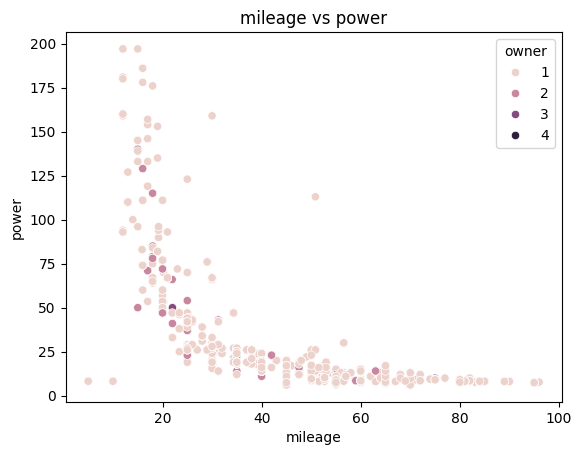

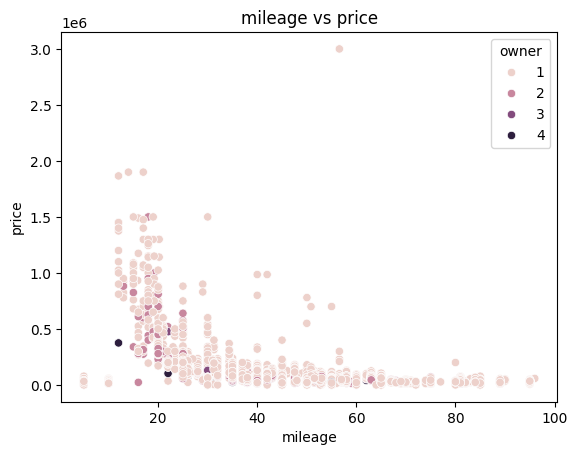

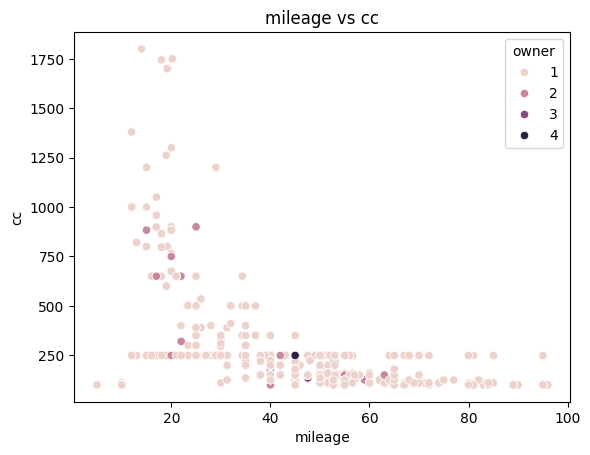

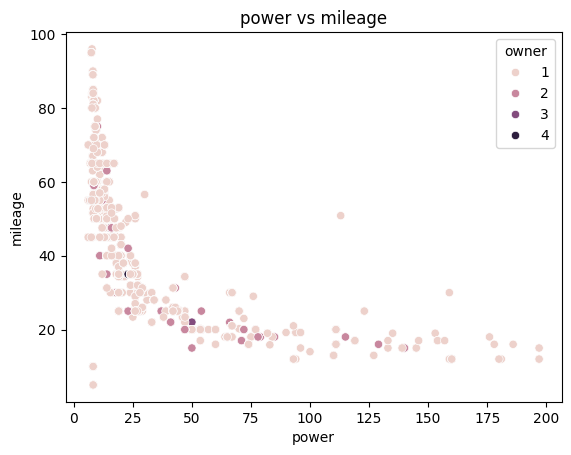

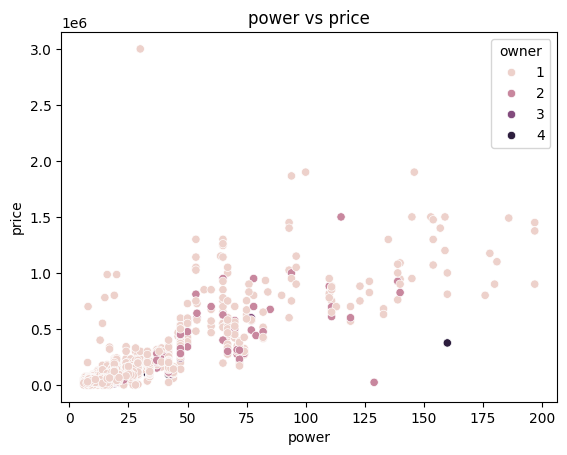

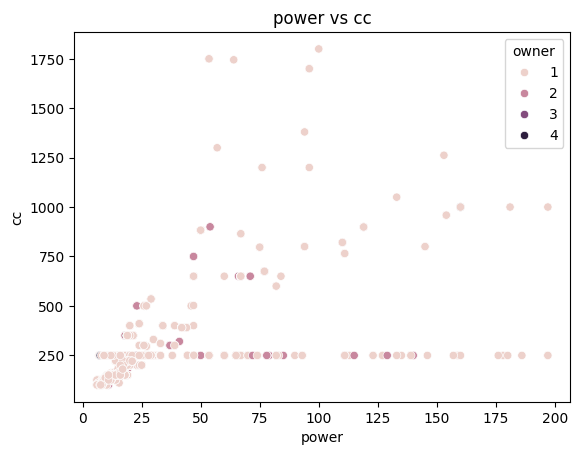

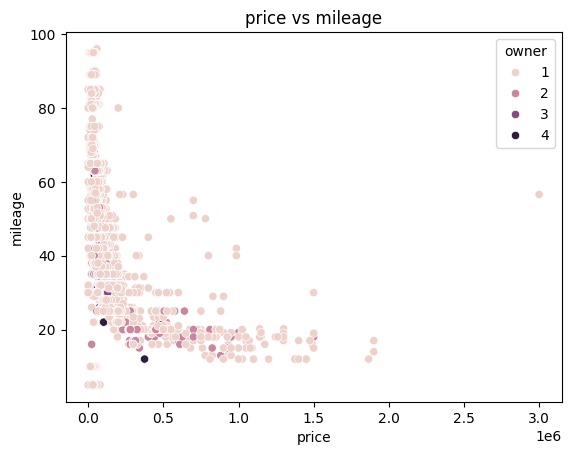

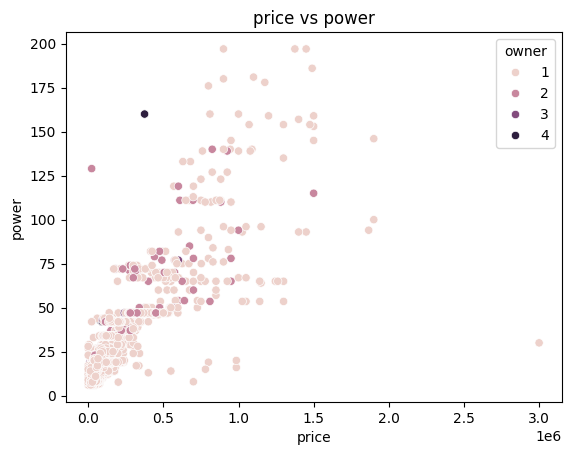

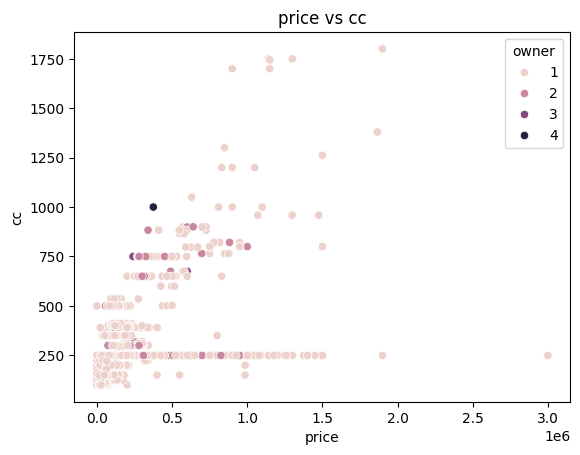

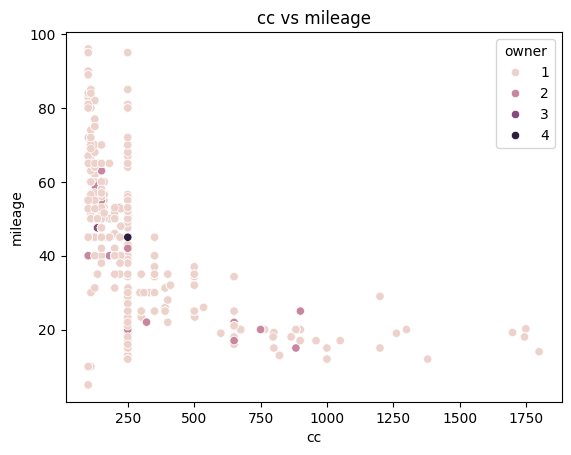

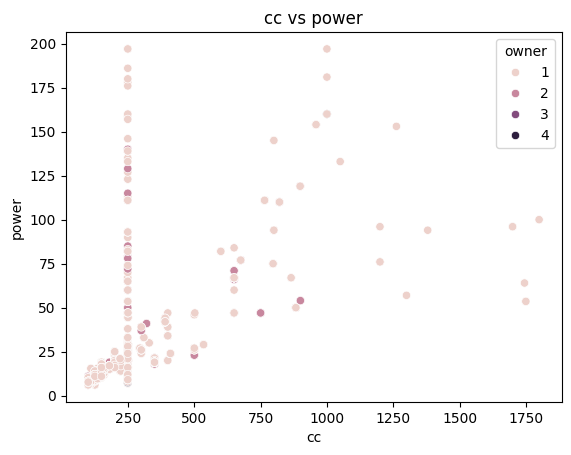

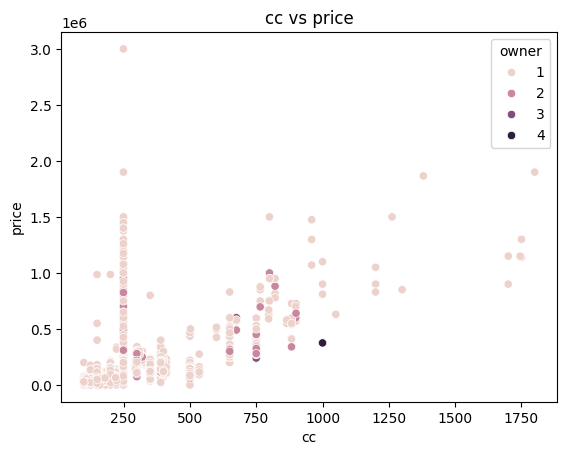

In [108]:
for i in most_corr_col:
    for j in most_corr_col:
        if i != j:
            sns.scatterplot(x=i, y=j, data=bikes, hue="owner", alpha=1.0);
            plt.title(f"{i} vs {j}");
            plt.show();

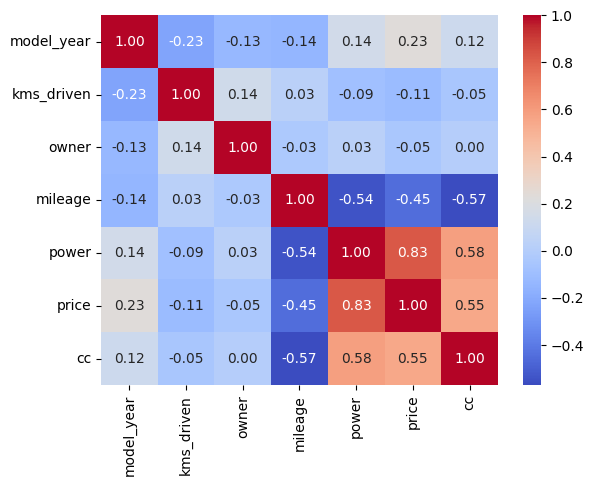

<Figure size 1600x1800 with 0 Axes>

In [93]:
sns.heatmap(bikes[bikes.select_dtypes(include=['number']).columns.values].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.figure(figsize=(16, 18))
plt.show()

In [94]:
bikes

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.000000
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.000000
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,249.194653
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.000000
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.000000
...,...,...,...,...,...,...,...,...,...,...
7852,Yamaha Yzf-R15 150Cc 2011,2011,7000.0,1,Agra,42.0,16.0,55000,Yamaha,150.000000
7853,Bajaj Discover 100Cc 2015,2015,80.0,1,Delhi,80.0,7.7,28000,Bajaj,100.000000
7854,Bajaj Pulsar 180Cc 2016,2016,6407.0,1,Bangalore,65.0,17.0,61740,Bajaj,180.000000
7855,Bajaj V15 150Cc 2016,2016,7524.0,1,Bangalore,57.0,11.0,49000,Bajaj,150.000000


In [95]:
bikes.dtypes

model_name     object
model_year      int64
kms_driven    float64
owner           int64
location       object
mileage       float64
power         float64
price           int64
brand          object
cc            float64
dtype: object

In [96]:
bikes.head()

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.000000
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.000000
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,249.194653
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.000000
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.000000


In [97]:
bikes.isnull().sum()

model_name     0
model_year     0
kms_driven     0
owner          0
location      19
mileage        0
power          0
price          0
brand          0
cc             0
dtype: int64

In [98]:
bikes[bikes["location"].isnull()]

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
1131,Honda Cbr 150R 150Cc 2014,2014,22500.0,1,NaN,38.000000,18.0,55000,Honda,150.000000
1186,Hero Cbz Xtreme 150Cc 2015,2015,23385.0,2,NaN,65.000000,14.0,20517,Hero,150.000000
1296,Um Renegade Commando 2018,2018,6500.0,2,NaN,35.000000,24.0,100000,Um,249.194653
1845,Yamaha Fazer 150Cc 2015,2015,45.0,1,NaN,45.000000,13.0,31250,Yamaha,150.000000
1894,Ktm Rc 200Cc Abs 2019,2019,20000.0,1,NaN,35.000000,25.0,165900,Ktm,200.000000
1916,Bajaj V15 150Cc 2017,2017,28000.0,2,NaN,57.000000,11.0,32000,Bajaj,150.000000
2824,Honda Cb Shine 125Cc 2014,2014,65.0,1,NaN,65.000000,10.0,40680,Honda,125.000000
2851,Yamaha Fz S V 2.0 150Cc 2018,2018,58.0,1,NaN,58.000000,13.0,65000,Yamaha,150.000000
2855,Royal Enfield Classic 350Cc 2015,2015,16500.0,1,NaN,35.000000,19.0,109400,Royal,350.000000
2959,Hero Splendor Ismart 110Cc 2015,2015,39571.0,1,NaN,45.000000,7.0,24000,Hero,110.000000


In [99]:
bikes.describe()

,model_year,kms_driven,owner,mileage,power,price,cc
count,7857.000000,7857.000000,7857.000000,7857.000000,7857.000000,7.857000e+03,7857.000000
mean,2015.367698,17277.018767,1.168003,44.053529,20.486665,1.067913e+05,249.194653
std,4.001443,26753.488250,0.479232,15.999072,15.045326,1.389261e+05,143.204845
min,1950.000000,0.000000,1.000000,5.000000,6.100000,0.000000e+00,100.000000
25%,2014.000000,104.000000,1.000000,35.000000,14.000000,4.200000e+04,150.000000
50%,2016.000000,11000.000000,1.000000,40.000000,19.000000,7.500000e+04,220.000000
75%,2018.000000,25000.000000,1.000000,55.000000,24.000000,1.250000e+05,350.000000
max,2021.000000,1000000.000000,4.000000,96.000000,197.000000,3.000000e+06,1800.000000


In [100]:
bikes2=BikePreprocess(pd.read_csv('bikes.csv')).preprocess_dataset()

In [101]:
bikes2

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.0
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.0
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,250.0
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.0
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.0
...,...,...,...,...,...,...,...,...,...,...
7852,Yamaha Yzf-R15 150Cc 2011,2011,7000.0,1,Agra,42.0,16.0,55000,Yamaha,150.0
7853,Bajaj Discover 100Cc 2015,2015,80.0,1,Delhi,80.0,7.7,28000,Bajaj,100.0
7854,Bajaj Pulsar 180Cc 2016,2016,6407.0,1,Bangalore,65.0,17.0,61740,Bajaj,180.0
7855,Bajaj V15 150Cc 2016,2016,7524.0,1,Bangalore,57.0,11.0,49000,Bajaj,150.0


In [102]:
bikes

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
0,Bajaj Avenger Cruise 220 2017,2017,17000.0,1,Hyderabad,35.0,19.0,63500,Bajaj,220.000000
1,Royal Enfield Classic 350Cc 2016,2016,50000.0,1,Hyderabad,35.0,19.0,115000,Royal,350.000000
2,Hyosung Gt250R 2012,2012,14795.0,1,Hyderabad,30.0,28.0,300000,Hyosung,249.194653
3,Bajaj Dominar 400 Abs 2017,2017,28.0,1,Pondicherry,28.0,34.0,100000,Bajaj,400.000000
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.000000
...,...,...,...,...,...,...,...,...,...,...
7852,Yamaha Yzf-R15 150Cc 2011,2011,7000.0,1,Agra,42.0,16.0,55000,Yamaha,150.000000
7853,Bajaj Discover 100Cc 2015,2015,80.0,1,Delhi,80.0,7.7,28000,Bajaj,100.000000
7854,Bajaj Pulsar 180Cc 2016,2016,6407.0,1,Bangalore,65.0,17.0,61740,Bajaj,180.000000
7855,Bajaj V15 150Cc 2016,2016,7524.0,1,Bangalore,57.0,11.0,49000,Bajaj,150.000000


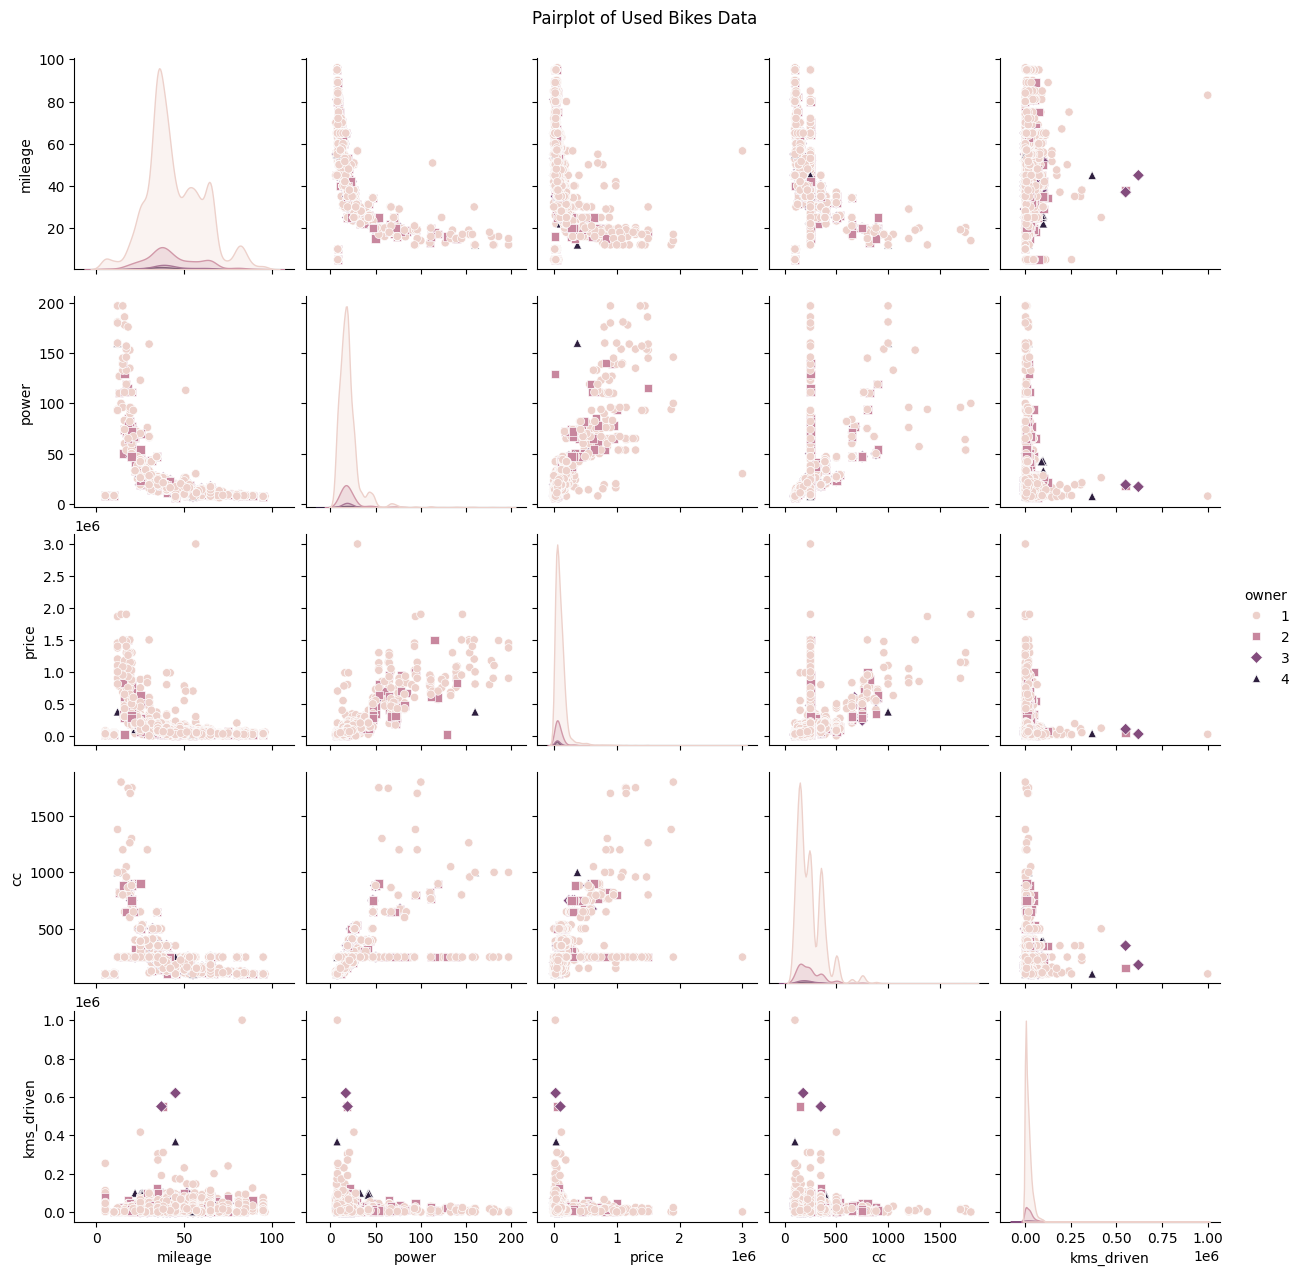

In [103]:
sns.pairplot(bikes, hue="owner", vars=["mileage", "power", "price", "cc", "kms_driven"], diag_kind="kde", markers=["o", "s", "D", "^"]);
plt.suptitle("Pairplot of Used Bikes Data", y=1.02)
plt.show()

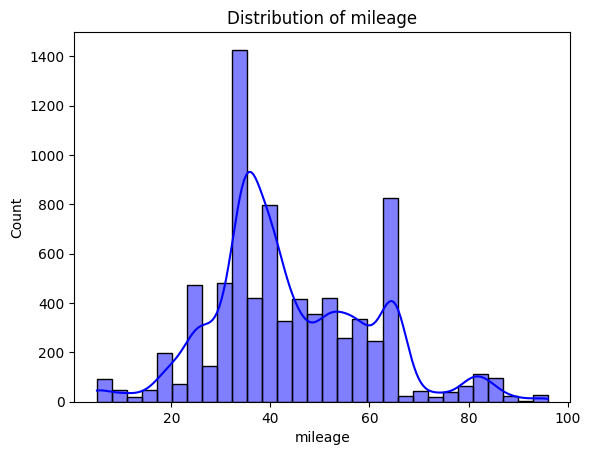

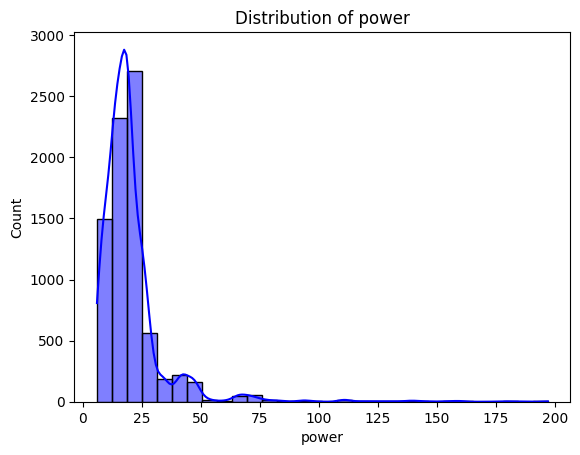

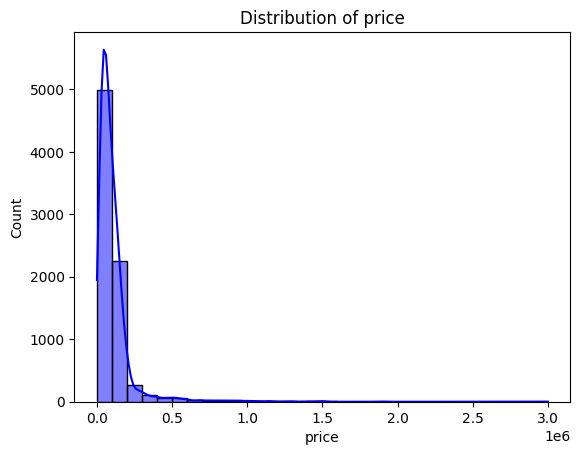

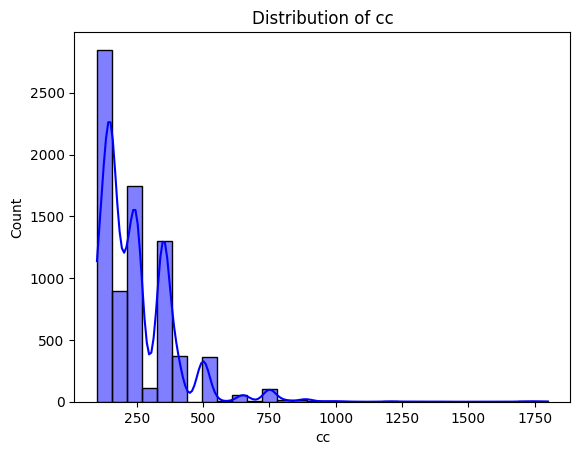

In [104]:
for i in most_corr_col:
    sns.histplot(bikes[i], kde=True, bins=30, color='blue', edgecolor='black');
    plt.title(f"Distribution of {i}")
    plt.show();

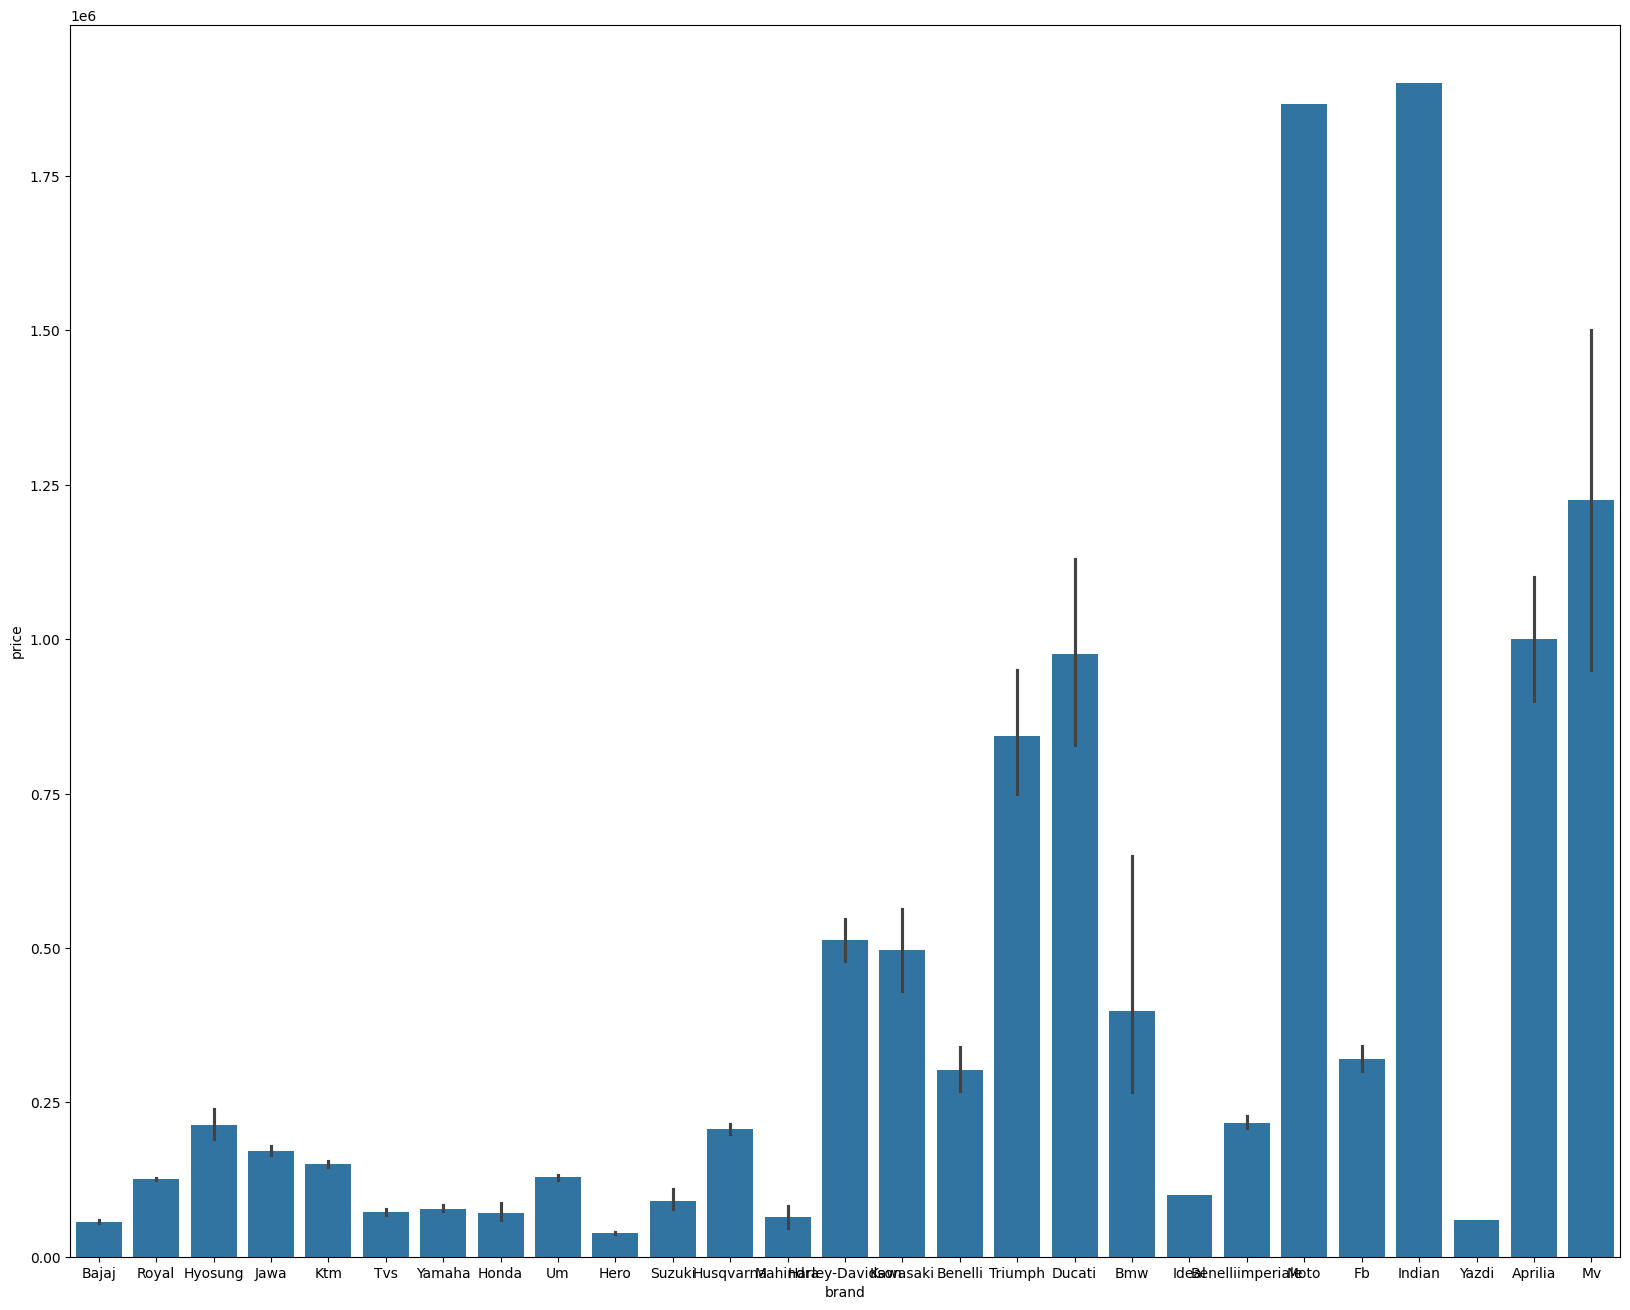

In [105]:
plt.figure(figsize=(20, 16))
sns.barplot(x="brand", y="price", data=bikes);
plt.show();

In [106]:
most_corr_col

['mileage', 'power', 'price', 'cc']

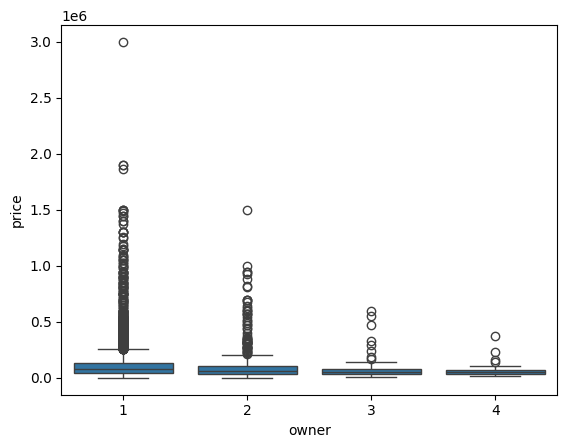

In [107]:
sns.boxplot(x="owner", y="price", data=bikes);
plt.show();


In [113]:
from preprocessing_d import BikePreprocess
bikes2=BikePreprocess(pd.read_csv('bikes.csv')).preprocess_dataset()
bikes2[bikes2["brand"] == "Jawa"].head(2)

,model_name,model_year,kms_driven,owner,location,mileage,power,price,brand,cc
4,Jawa Perak 330Cc 2020,2020,2000.0,1,Bangalore,30.0,30.0,197500,Jawa,330.0
157,Jawa Forty Two 295Cc 2019,2019,4930.0,1,Moradabad,30.0,27.0,140000,Jawa,295.0
